# Analyze Bay Area Bike Share Data

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, you will put yourself in the shoes of a data analyst performing an exploratory analysis on the data. You will take a look at two of the major parts of the data analysis process: data wrangling and exploratory data analysis. But before you even start looking at data, think about some questions you might want to understand about the bike share data. Consider, for example, if you were working for Bay Area Bike Share: what kinds of information would you want to know about in order to make smarter business decisions? Or you might think about if you were a user of the bike share service. What factors might influence how you would want to use the service?

**Question 1**: Write at least two questions you think could be answered by data.

**Answer**: If I was working for Bay Area Bike Share, I would like to know:
1. Who used our service, what was their trip for? Commute, travel or other purpose?
2. Which stations and routes are most popular, and why?
3. How do weather, holidays, games and special events influence rides?

## Using Visualizations to Communicate Findings in Data

As a data analyst, the ability to effectively communicate findings is a key part of the job. After all, your best analysis is only as good as your ability to communicate it.

In 2014, Bay Area Bike Share held an [Open Data Challenge](http://www.bayareabikeshare.com/datachallenge-2014) to encourage data analysts to create visualizations based on their open data set. You’ll create your own visualizations in this project, but first, take a look at the [submission winner for Best Analysis](http://thfield.github.io/babs/index.html) from Tyler Field. Read through the entire report to answer the following question:

**Question 2**: What visualizations do you think provide the most interesting insights? Are you able to answer either of the questions you identified above based on Tyler’s analysis? Why or why not?

**Answer**: "The heatmap diagram of rides" provides me the most interesting insights. Tyler’s analysis includes both user type, time and geographical dimensions, from time period of day, trips on weekends, trips on special days, to most popular cities, stations and routes, step by step derived conclusions which answered all my questions.

## Data Wrangling

Now it's time to explore the data for yourself. Year 1 and Year 2 data from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data) page have already been provided with the project materials; you don't need to download anything extra. The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

When dealing with a lot of data, it can be useful to start by working with only a sample of the data. This way, it will be much easier to check that our data wrangling steps are working since our code will take less time to complete. Once we are satisfied with the way things are working, we can then set things up to work on the dataset as a whole.

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. You'll start by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below will take the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).

First, load all of the packages and functions that you'll be using in your analysis by running the first code cell below. Then, run the second code cell to read a subset of the first trip data file, and write a new file containing just the subset we are initially interested in.

In [1]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [2]:
# file locations
file_in  = 'Data/201402_trip_data.csv'
file_out = 'Data/201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell will read in the sampled data file that you created in the previous cell, and print out the first few rows of the table.

In [3]:
sample_data = pd.read_csv('Data/201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. Run the below code cell to see how the station information is structured, then observe how the code will create the station-city mapping. Note that the station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function will allow us to combine the station information across all three parts of our data when we are ready to explore everything.

In [4]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('Data/201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


You can now use the mapping to condense the trip data to the selected columns noted above. This will be performed in the `summarise_data()` function below. As part of this function, the `datetime` module is used to **p**arse the timestamp strings from the original data file as datetime objects (`strptime`), which can then be output in a different string **f**ormat (`strftime`). The parsed objects also have a variety of attributes and methods to quickly obtain

There are two tasks that you will need to complete to finish the `summarise_data()` function. First, you should perform an operation to convert the trip durations from being in terms of seconds to being in terms of minutes. (There are 60 seconds in a minute.) Secondly, you will need to create the columns for the year, month, hour, and day of the week. Take a look at the [documentation for datetime objects in the datetime module](https://docs.python.org/2/library/datetime.html#datetime-objects). **Find the appropriate attributes and method to complete the below code.**

In [5]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%w')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

**Question 3**: Run the below code block to call the `summarise_data()` function you finished in the above cell. It will take the data contained in the files listed in the `trip_in` and `station_data` variables, and write a new file at the location specified in the `trip_out` variable. If you've performed the data wrangling correctly, the below code block will print out the first few lines of the dataframe and a message verifying that the data point counts are correct.

In [6]:
# Process the data by running the function we wrote above.
station_data = ['Data/201402_station_data.csv']
trip_in = ['Data/201309_trip_data.csv']
trip_out = 'Data/201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,4,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,4,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,4,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,4,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,4,San Francisco,San Francisco,Subscriber


All counts are as expected!


## Exploratory Data Analysis

Now that you have some data saved to a file, let's look at some initial trends in the data. Some code has already been written for you in the `babs_visualizations.py` script to help summarize and visualize the data; this has been imported as the functions `usage_stats()` and `usage_plot()`. In this section we'll walk through some of the things you can do with the functions, and you'll use the functions for yourself in the last part of the project. First, run the following cell to load the data, then use the `usage_stats()` function to see the total number of trips made in the first month of operations, along with some statistics regarding how long trips took.

In [7]:
trip_data = pd.read_csv('Data/201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

You should see that there are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration (the point where 50% of trips are shorter, and 50% are longer). In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type. One easy way to build an intuition about the data is to plot it. We'll use the `usage_plot()` function for this. The second argument of the function allows us to count up the trips across a selected variable, displaying the information in a plot. The expression below will show how many customer and how many subscriber trips were made. Try it out!

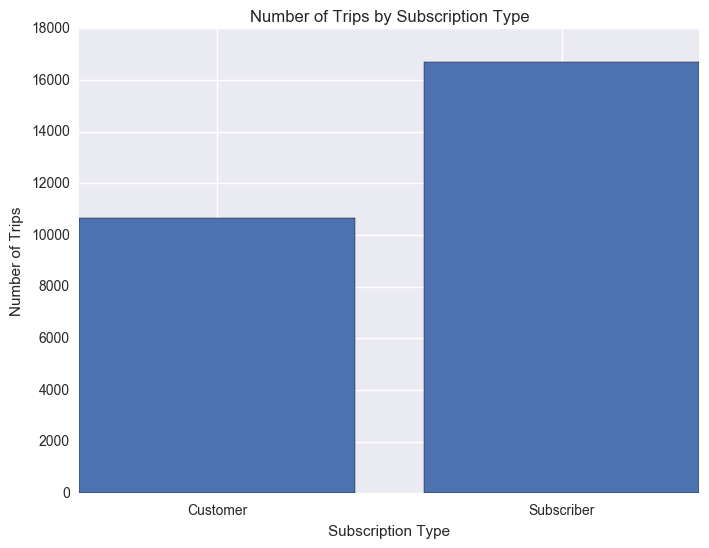

In [8]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

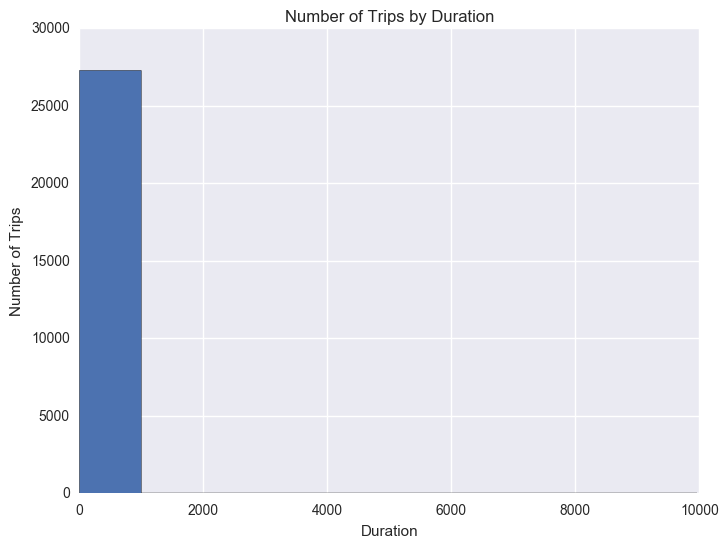

In [9]:
usage_plot(trip_data, 'duration')

Looks pretty strange, doesn't it? Take a look at the duration values on the x-axis. Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. Based on the statistics we got out of `usage_stats()`, we should have expected some trips with very long durations that bring the average to be so much higher than the median: the plot shows this in a dramatic, but unhelpful way.

When exploring the data, you will often need to work with visualization function parameters in order to make the data easier to understand. Here's where the third argument of the `usage_plot()` function comes in. Filters can be set for data points as a list of conditions. Let's start by limiting things to trips of less than 60 minutes.

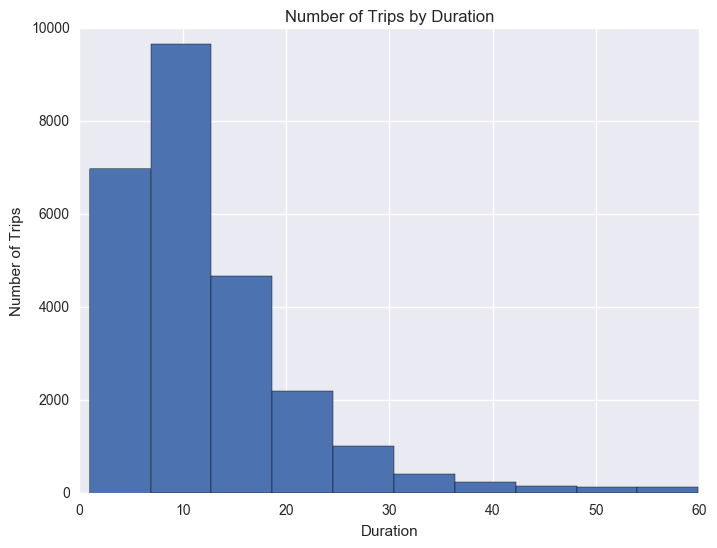

In [10]:
usage_plot(trip_data, 'duration', ['duration < 60'])

This is looking better! You can see that most trips are indeed less than 30 minutes in length, but there's more that you can do to improve the presentation. Since the minimum duration is not 0, the left hand bar is slighly above 0. We want to be able to tell where there is a clear boundary at 30 minutes, so it will look nicer if we have bin sizes and bin boundaries that correspond to some number of minutes. Fortunately, you can use the optional "boundary" and "bin_width" parameters to adjust the plot. By setting "boundary" to 0, one of the bin edges (in this case the left-most bin) will start at 0 rather than the minimum trip duration. And by setting "bin_width" to 5, each bar will count up data points in five-minute intervals.

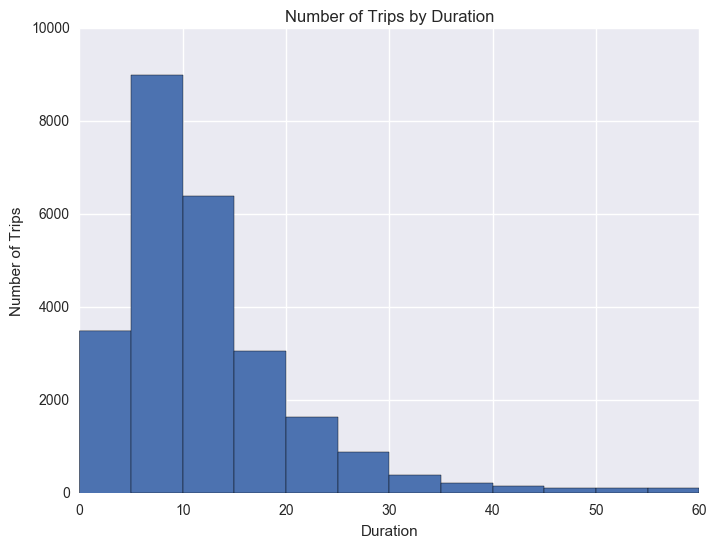

In [11]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

**Question 4**: Which five-minute trip duration shows the most number of trips? Approximately how many trips were made in this range?

**Answer**: The duration of 5-10 minutes shows the most number of trips which is approximately 9000 trips.

Visual adjustments like this might be small, but they can go a long way in helping you understand the data and convey your findings to others.

## Performing Your Own Analysis

Now that you've done some exploration on a small sample of the dataset, it's time to go ahead and put together all of the data in a single file and see what trends you can find. The code below will use the same `summarise_data()` function as before to process data. After running the cell below, you'll have processed all the data into a single data file. Note that the function will not display any output while it runs, and this can take a while to complete since you have much more data than the sample you worked with above.

In [12]:
station_data = ['Data/201402_station_data.csv',
                'Data/201408_station_data.csv',
                'Data/201508_station_data.csv' ]
trip_in = ['Data/201402_trip_data.csv',
           'Data/201408_trip_data.csv',
           'Data/201508_trip_data.csv' ]
trip_out = 'Data/babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

Since the `summarise_data()` function has created a standalone file, the above cell will not need to be run a second time, even if you close the notebook and start a new session. You can just load in the dataset and then explore things from there.

In [13]:
trip_data = pd.read_csv('Data/babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,4,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,4,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,4,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,4,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,4,San Francisco,San Francisco,Subscriber


#### Now it's your turn to explore the new dataset with `usage_stats()` and `usage_plot()` and report your findings! Here's a refresher on how to use the `usage_plot()` function:
- first argument (required): loaded dataframe from which data will be analyzed.
- second argument (required): variable on which trip counts will be divided.
- third argument (optional): data filters limiting the data points that will be counted. Filters should be given as a list of conditions, each element should be a string in the following format: `'<field> <op> <value>'` using one of the following operations: >, <, >=, <=, ==, !=. Data points must satisfy all conditions to be counted or visualized. For example, `["duration < 15", "start_city == 'San Francisco'"]` retains only trips that originated in San Francisco and are less than 15 minutes long.

If data is being split on a numeric variable (thus creating a histogram), some additional parameters may be set by keyword.
- "n_bins" specifies the number of bars in the resultant plot (default is 10).
- "bin_width" specifies the width of each bar (default divides the range of the data by number of bins). "n_bins" and "bin_width" cannot be used simultaneously.
- "boundary" specifies where one of the bar edges will be placed; other bar edges will be placed around that value (this may result in an additional bar being plotted). This argument may be used alongside the "n_bins" and "bin_width" arguments.

You can also add some customization to the `usage_stats()` function as well. The second argument of the function can be used to set up filter conditions, just like how they are set up in `usage_plot()`.

In [14]:
usage_stats(trip_data, ["duration < 30", "start_city == 'San Francisco'"])

There are 574542 data points (85.76%) matching the filter criteria.
The average duration of trips is 9.40 minutes.
The median trip duration is 8.45 minutes.
25% of trips are shorter than 5.78 minutes.
25% of trips are longer than 11.87 minutes.


array([  5.78333333,   8.45      ,  11.86666667])

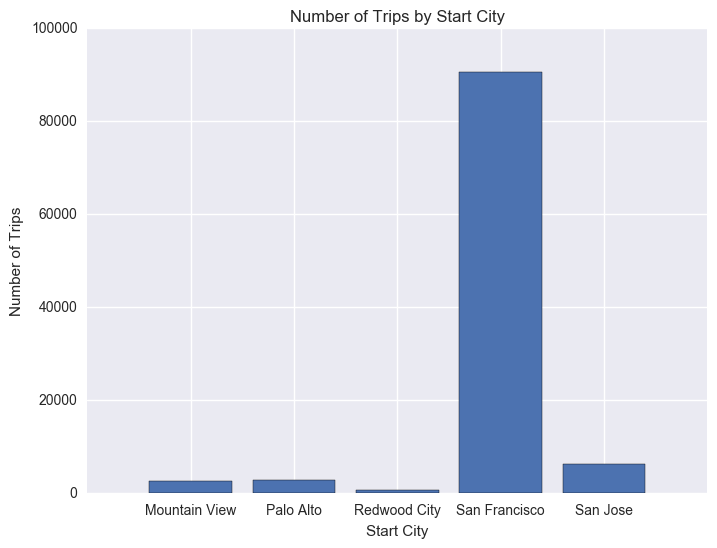

In [15]:
usage_plot(trip_data, 'start_city', ["subscription_type == 'Customer'"],
           boundary=0, n_bins = 5)

Explore some different variables using the functions above and take note of some trends you find. Feel free to create additional cells if you want to explore the dataset in other ways or multiple ways.

One you're done with your explorations, copy the two visualizations you found most interesting into the cells below, then answer the following questions with a few sentences describing what you found and why you selected the figures. Make sure that you adjust the number of bins or the bin limits so that they effectively convey data findings. Feel free to supplement this with any additional numbers generated from `usage_stats()` or place multiple visualizations to support your observations.

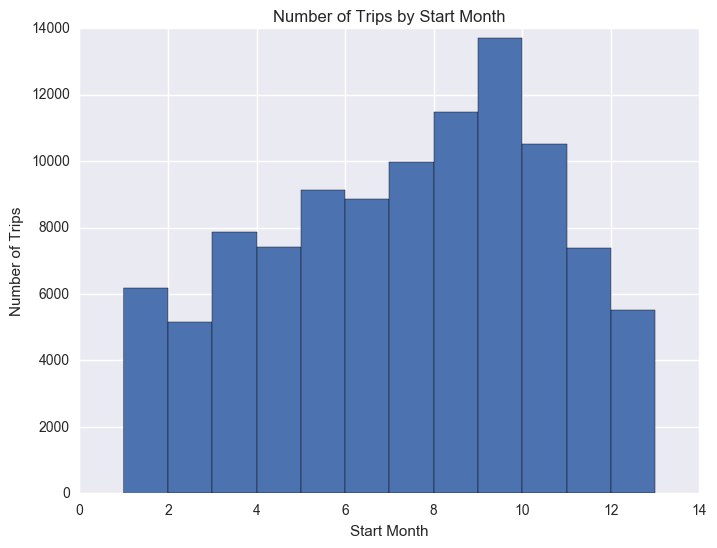

In [16]:
# Final Plot 1
usage_plot(trip_data, 'start_month', ["subscription_type == 'Customer'"],
           boundary=0, bin_width = 1)

**Question 5a**: What is interesting about the above visualization? Why did you select it?

**Answer**: It shows the trips were influenced by season. The rides droped down in rainy season and winter but reached to top in the warm September.

In [17]:
def re_summarise_data(trip_in, station_data, trip_out):
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_station', 'end_station', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%w')
                    
                    # add start and end station depending on file
                    new_point['start_station'] = row['Start Station']
                    new_point['end_station'] = row['End Station']
                    
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [18]:
station_data = ['Data/201402_station_data.csv',
                'Data/201408_station_data.csv',
                'Data/201508_station_data.csv' ]
trip_in = ['Data/201402_trip_data.csv',
           'Data/201408_trip_data.csv',
           'Data/201508_trip_data.csv' ]
trip_out = 'Data/babs_y1_y2_summary.csv'

re_summarise_data(trip_in, station_data, trip_out)

trip_data = pd.read_csv('Data/babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_station,end_station,subscription_type
0,1.050000,2013-08-29,2013,8,14,4,South Van Ness at Market,South Van Ness at Market,Subscriber
1,1.166667,2013-08-29,2013,8,14,4,San Jose City Hall,San Jose City Hall,Subscriber
2,1.183333,2013-08-29,2013,8,10,4,Mountain View City Hall,Mountain View City Hall,Subscriber
3,1.283333,2013-08-29,2013,8,11,4,San Jose City Hall,San Jose City Hall,Subscriber
4,1.383333,2013-08-29,2013,8,12,4,South Van Ness at Market,Market at 10th,Subscriber


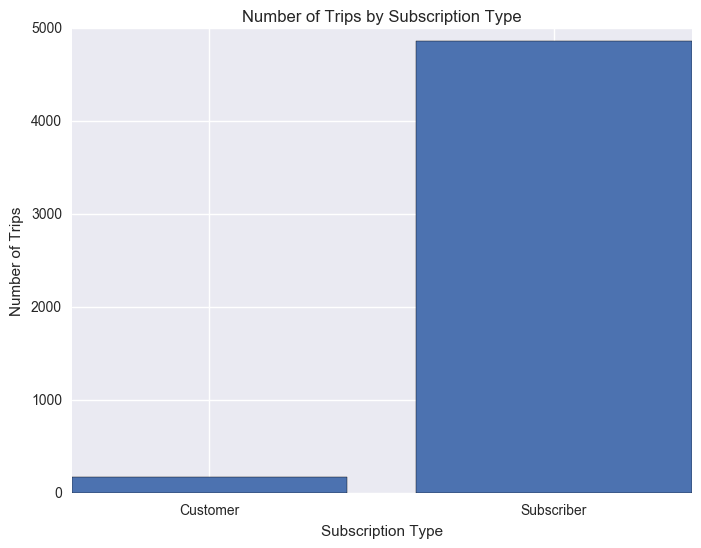

In [19]:
# Final Plot 2
usage_plot(trip_data, 'subscription_type',
           ["start_station == 'Townsend at 7th'",
            "end_station == 'San Francisco Caltrain (Townsend at 4th)'"],
           boundary=0, bin_width = 1)

**Question 5b**: What is interesting about the above visualization? Why did you select it?

**Answer**: According to Tyler’s analysis, 'Townsend at 7th' to 'San Francisco Caltrain (Townsend at 4th)' station is the most popular route of all rides, this visualization shows corresponding distribution among subscribers vs customers.

## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about our data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the code given. Instead of just looking at number of trips on the outcome axis, you could see what features affect things like trip duration. We also haven't looked at how the weather data ties into bike usage.

**Question 6**: Think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: Well, I am a newbie，but I think it's more likely I can apply the technique in E-commerce business. I want to know about how to deal with data; learn how to analyze them and make prediction; be able to communicate my analyzed result effectively to others.